In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Reading the data
data = pd.read_excel(r'C:\Users\sreeh\DSA\Project testing\ECommerceDataset.xlsx',sheet_name='E Comm')
pd.set_option('display.max_columns',None)

In [3]:
# Displaying a small chunk of data.
data.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [4]:
# Changing the same values with different respresentations into one single value
data['PreferredLoginDevice'] = data['PreferredLoginDevice'].replace('Phone', 'Mobile Phone')
data['PreferredPaymentMode'] = data['PreferredPaymentMode'].replace('CC', 'Credit Card').replace('COD', 'Cash on Delivery')
data['PreferedOrderCat'] = data['PreferedOrderCat'].replace('Mobile', 'Mobile Phone')

In [5]:
# Rounding the OrderCount because orders have to be whole numbers.
data['OrderCount'] = round(data['OrderCount'])

In [6]:
# Changing the type of columns.
data['CityTier'] = data['CityTier'].astype('object')
data['SatisfactionScore'] = data['SatisfactionScore'].astype('object')
data['Complain'] = data['Complain'].astype('object')

In [7]:
# Fill the missing values using KNN.
missing_cols = [col for col in data.columns if data[col].isnull().any()]
from sklearn.impute import KNNImputer
impute_knn = KNNImputer(n_neighbors=5)
data_missing = data[missing_cols]
imputed_data = impute_knn.fit_transform(data_missing)
data_imputed = pd.concat([data.drop(missing_cols, axis=1), pd.DataFrame(imputed_data, columns=missing_cols)], axis=1)

In [8]:
# Winsorize the values above 99th percentile to 99th percentile
from scipy.stats.mstats import winsorize
winsorize(data_imputed['Tenure'], limits=(0, 0.01), inplace=True)

masked_array(data=[ 4. ,  9.8,  8. , ...,  1. , 23. ,  8. ],
             mask=False,
       fill_value=1e+20)

In [9]:
# Winsorize the values above 95th percentile to 95th percentile
winsorize(data_imputed['NumberOfAddress'], limits=(0, 0.05), inplace=True)

masked_array(data=[9, 7, 6, ..., 3, 4, 4],
             mask=False,
       fill_value=999999,
            dtype=int64)

In [10]:
# Conducting Two Sample T-Test to see which numerical columns to select
from scipy.stats import ttest_ind
def num_stats(num_col):
    group_0 = data_imputed[data_imputed['Churn']==0][num_col]
    group_1 = data_imputed[data_imputed['Churn']==1][num_col]

    t_stat, p_value = ttest_ind(group_0,group_1,equal_var=False)

    print('P-value : ', p_value)
    if(p_value<0.05):
        print('Reject null hypothesis')
    else:
        print('Do not reject null hypothesis')

In [11]:
# Conducting chi-square test of independence on categorical columns.
from scipy.stats import chi2_contingency
def chisq_test(cat_col, df):
    CrossTabResult=pd.crosstab(index=df['Churn'], columns=df[cat_col])
    ChiSqResult = chi2_contingency(CrossTabResult)
        
    if (ChiSqResult[1] < 0.05):
        print('P-Value :', ChiSqResult[1])
        print('Reject null hypothesis')
    else:
        print('P-Value :', ChiSqResult[1])
        print('Do not reject null hypothesis')

In [12]:
numerical_cols = data_imputed.select_dtypes(include=['int', 'float']).columns.tolist()
numerical_cols.remove('Churn')
categorical_cols = data_imputed.select_dtypes(include=['object']).columns.tolist()

In [13]:
for col in numerical_cols:
    print('Column Name : ', col)
    num_stats(col)
    print('---------------------------------------------')

Column Name :  CustomerID
P-value :  0.15488517765319548
Do not reject null hypothesis
---------------------------------------------
Column Name :  NumberOfDeviceRegistered
P-value :  6.939036502330203e-16
Reject null hypothesis
---------------------------------------------
Column Name :  NumberOfAddress
P-value :  0.002854282341194818
Reject null hypothesis
---------------------------------------------
Column Name :  CashbackAmount
P-value :  4.3622347482862773e-42
Reject null hypothesis
---------------------------------------------
Column Name :  Tenure
P-value :  2.867207265331189e-210
Reject null hypothesis
---------------------------------------------
Column Name :  WarehouseToHome
P-value :  4.746695651230401e-08
Reject null hypothesis
---------------------------------------------
Column Name :  HourSpendOnApp
P-value :  0.34558360564922597
Do not reject null hypothesis
---------------------------------------------
Column Name :  OrderAmountHikeFromlastYear
P-value :  0.571061713

In [14]:
for col in categorical_cols:
    print('Column Name : ', col)
    chisq_test(col, data_imputed)
    print('---------------------------------------------')

Column Name :  PreferredLoginDevice
P-Value : 0.0001477040239947965
Reject null hypothesis
---------------------------------------------
Column Name :  CityTier
P-Value : 1.2612000812079956e-09
Reject null hypothesis
---------------------------------------------
Column Name :  PreferredPaymentMode
P-Value : 1.4978570960706276e-10
Reject null hypothesis
---------------------------------------------
Column Name :  Gender
P-Value : 0.030820940334890086
Reject null hypothesis
---------------------------------------------
Column Name :  PreferedOrderCat
P-Value : 3.11924340428766e-61
Reject null hypothesis
---------------------------------------------
Column Name :  SatisfactionScore
P-Value : 2.4233349782737515e-14
Reject null hypothesis
---------------------------------------------
Column Name :  MaritalStatus
P-Value : 1.073011277910542e-41
Reject null hypothesis
---------------------------------------------
Column Name :  Complain
P-Value : 2.6644609654641377e-78
Reject null hypothesis


In [15]:
# Selecting columns where we accept the null hypothesis of the column does not affect the target 'Churn'
data_imputed.drop(columns=['CustomerID','HourSpendOnApp','OrderCount','OrderAmountHikeFromlastYear','CouponUsed'],axis=1,inplace=True)

In [16]:
# Using one hot encoding for the categorical columns.
data_imputed[categorical_cols] = data_imputed[categorical_cols].astype('category')
df_encoded = pd.get_dummies(data_imputed,columns=categorical_cols)

In [17]:
# The data is imbalanced. So we use an oversampling method of SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=33)
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']
x_smote, y_smote = smote.fit_resample(X, y)
df_encoded = pd.DataFrame(x_smote, columns=df_encoded.drop('Churn', axis=1).columns)
df_encoded['Churn'] = y_smote

In [18]:
from sklearn.preprocessing import StandardScaler
X = df_encoded.drop('Churn', axis=1)
cols = X.columns
y= df_encoded.Churn
# Using StandarScaler to scale the values
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X,columns=cols)

In [19]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state= 42)

In [20]:
import optuna
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 200)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 1.0)
    algorithm = trial.suggest_categorical("algorithm", ["SAMME"])
    base_estimator = trial.suggest_categorical("base_estimator", ["decision_tree", "logistic_regression", "svm"])

    if base_estimator == "decision_tree":
        criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
        max_depth = trial.suggest_int("max_depth", 2, 32)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 10)

        base_estimator = DecisionTreeClassifier(
            criterion=criterion,
            max_depth=max_depth,
            min_samples_split=min_samples_split
        )
    elif base_estimator == "logistic_regression":
        C = trial.suggest_float("C", 0.1, 10.0)
        penalty = trial.suggest_categorical("penalty", ["l2",None])
        solver = trial.suggest_categorical("solver", ["lbfgs"])

        base_estimator = LogisticRegression(
            C=C,
            penalty=penalty,
            solver=solver
        )
    elif base_estimator == "svm":
        C = trial.suggest_float("C", 0.1, 10.0)
        kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly", "sigmoid"])
        gamma = trial.suggest_categorical("gamma", ["scale", "auto"])

        base_estimator = SVC(
            C=C,
            kernel=kernel,
            gamma=gamma
        )

    adaboost = AdaBoostClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        algorithm=algorithm,
        estimator=base_estimator
    )

    adaboost.fit(X_train, y_train)

    y_pred = adaboost.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
best_params = study.best_params
best_accuracy = study.best_value
print("Best parameters:", best_params)
print("Best accuracy:", best_accuracy)

[I 2023-08-04 15:04:46,676] A new study created in memory with name: no-name-a7050037-f858-4ae4-a3d0-b6fff10073c9
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Use

C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None wil

[I 2023-08-04 15:04:51,337] Trial 1 finished with value: 0.9886120996441281 and parameters: {'n_estimators': 76, 'learning_rate': 0.5167780624240194, 'algorithm': 'SAMME', 'base_estimator': 'decision_tree', 'criterion': 'gini', 'max_depth': 13, 'min_samples_split': 2}. Best is trial 1 with value: 0.9886120996441281.
[I 2023-08-04 15:04:51,506] Trial 2 finished with value: 0.898220640569395 and parameters: {'n_estimators': 113, 'learning_rate': 0.9840815469598807, 'algorithm': 'SAMME', 'base_estimator': 'logistic_regression', 'C': 2.046326308119436, 'penalty': 'l2', 'solver': 'lbfgs'}. Best is trial 1 with value: 0.9886120996441281.
[I 2023-08-04 15:04:56,027] Trial 3 finished with value: 0.9871886120996441 and parameters: {'n_estimators': 109, 'learning_rate': 0.274227201799561, 'algorithm': 'SAMME', 'base_estimator': 'decision_tree', 'criterion': 'entropy', 'max_depth': 18, 'min_samples_split': 7}. Best is trial 1 with value: 0.9886120996441281.
[I 2023-08-04 15:04:58,172] Trial 4 fin

C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None wil

C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None wil

C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None wil

C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None wil

C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None wil

C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None wil

C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None wil

[I 2023-08-04 16:01:52,319] Trial 30 finished with value: 0.9903914590747331 and parameters: {'n_estimators': 144, 'learning_rate': 0.5803008401306909, 'algorithm': 'SAMME', 'base_estimator': 'decision_tree', 'criterion': 'gini', 'max_depth': 27, 'min_samples_split': 9}. Best is trial 28 with value: 0.9907473309608541.
[I 2023-08-04 16:01:58,691] Trial 31 finished with value: 0.9911032028469751 and parameters: {'n_estimators': 142, 'learning_rate': 0.574333672143362, 'algorithm': 'SAMME', 'base_estimator': 'decision_tree', 'criterion': 'gini', 'max_depth': 28, 'min_samples_split': 9}. Best is trial 31 with value: 0.9911032028469751.
[I 2023-08-04 16:02:05,331] Trial 32 finished with value: 0.9896797153024911 and parameters: {'n_estimators': 142, 'learning_rate': 0.5430881715156759, 'algorithm': 'SAMME', 'base_estimator': 'decision_tree', 'criterion': 'gini', 'max_depth': 28, 'min_samples_split': 9}. Best is trial 31 with value: 0.9911032028469751.
[I 2023-08-04 16:02:14,568] Trial 33 f

C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None wil

C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None wil

[I 2023-08-04 16:16:16,181] Trial 48 finished with value: 0.49857651245551604 and parameters: {'n_estimators': 118, 'learning_rate': 0.39878908357569787, 'algorithm': 'SAMME', 'base_estimator': 'svm', 'C': 3.5713754705245657, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 43 with value: 0.9918149466192171.
[I 2023-08-04 16:16:21,787] Trial 49 finished with value: 0.9886120996441281 and parameters: {'n_estimators': 148, 'learning_rate': 0.29096053945059297, 'algorithm': 'SAMME', 'base_estimator': 'decision_tree', 'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 9}. Best is trial 43 with value: 0.9918149466192171.
[I 2023-08-04 16:16:27,806] Trial 50 finished with value: 0.9896797153024911 and parameters: {'n_estimators': 135, 'learning_rate': 0.6625659036827993, 'algorithm': 'SAMME', 'base_estimator': 'decision_tree', 'criterion': 'gini', 'max_depth': 31, 'min_samples_split': 8}. Best is trial 43 with value: 0.9918149466192171.
[I 2023-08-04 16:16:34,367] Trial 51 finish

[I 2023-08-04 16:27:45,663] Trial 74 finished with value: 0.9914590747330961 and parameters: {'n_estimators': 150, 'learning_rate': 0.5262545660354817, 'algorithm': 'SAMME', 'base_estimator': 'decision_tree', 'criterion': 'gini', 'max_depth': 27, 'min_samples_split': 9}. Best is trial 58 with value: 0.9921708185053381.
[I 2023-08-04 16:27:45,876] Trial 75 finished with value: 0.9679715302491103 and parameters: {'n_estimators': 150, 'learning_rate': 0.5262071674828095, 'algorithm': 'SAMME', 'base_estimator': 'decision_tree', 'criterion': 'entropy', 'max_depth': 29, 'min_samples_split': 3}. Best is trial 58 with value: 0.9921708185053381.
[I 2023-08-04 16:27:53,180] Trial 76 finished with value: 0.9903914590747331 and parameters: {'n_estimators': 155, 'learning_rate': 0.5720176338520441, 'algorithm': 'SAMME', 'base_estimator': 'decision_tree', 'criterion': 'gini', 'max_depth': 25, 'min_samples_split': 9}. Best is trial 58 with value: 0.9921708185053381.
[I 2023-08-04 16:27:53,514] Trial 

C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None wil

C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None wil

[I 2023-08-04 16:31:50,635] Trial 92 finished with value: 0.9889679715302491 and parameters: {'n_estimators': 142, 'learning_rate': 0.38265778533299616, 'algorithm': 'SAMME', 'base_estimator': 'decision_tree', 'criterion': 'gini', 'max_depth': 25, 'min_samples_split': 9}. Best is trial 58 with value: 0.9921708185053381.
[I 2023-08-04 16:31:56,874] Trial 93 finished with value: 0.9900355871886121 and parameters: {'n_estimators': 136, 'learning_rate': 0.5884355985506668, 'algorithm': 'SAMME', 'base_estimator': 'decision_tree', 'criterion': 'gini', 'max_depth': 26, 'min_samples_split': 9}. Best is trial 58 with value: 0.9921708185053381.
[I 2023-08-04 16:32:01,335] Trial 94 finished with value: 0.9864768683274021 and parameters: {'n_estimators': 132, 'learning_rate': 0.42090403502943585, 'algorithm': 'SAMME', 'base_estimator': 'decision_tree', 'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 10}. Best is trial 58 with value: 0.9921708185053381.
[I 2023-08-04 16:32:05,816] Trial 9

Best parameters: {'n_estimators': 147, 'learning_rate': 0.42329791924956006, 'algorithm': 'SAMME', 'base_estimator': 'decision_tree', 'criterion': 'gini', 'max_depth': 27, 'min_samples_split': 7}
Best accuracy: 0.9921708185053381


In [27]:
best_params = study.best_params
best_accuracy = study.best_value
print("Best parameters:", best_params)
print("Best accuracy:", best_accuracy)

Best parameters: {'n_estimators': 147, 'learning_rate': 0.42329791924956006, 'algorithm': 'SAMME', 'base_estimator': 'decision_tree', 'criterion': 'gini', 'max_depth': 27, 'min_samples_split': 7}
Best accuracy: 0.9921708185053381


In [29]:
adaboost_best = AdaBoostClassifier(
    n_estimators=best_params['n_estimators'], # 147
    learning_rate=best_params['learning_rate'], # 0.42329791924956006
    algorithm=best_params['algorithm'], # SAMME
    estimator=DecisionTreeClassifier(criterion = best_params['criterion'], # gini
                                     max_depth = best_params['max_depth'], # 27
                                     min_samples_split = best_params['min_samples_split']) # 7
)

In [30]:
adaboost_best = adaboost_best.fit(X_train, y_train)

In [31]:
y_pred = adaboost_best.predict(X_test)

print("Accuracy = ",accuracy_score(y_test,y_pred))
print("Precision = ",precision_score(y_test,y_pred))
print("Recall = ",recall_score(y_test,y_pred))
print("F1 Score", f1_score(y_test,y_pred))

Accuracy =  0.9911032028469751
Precision =  0.9893917963224894
Recall =  0.992902767920511
F1 Score 0.9911441728657457


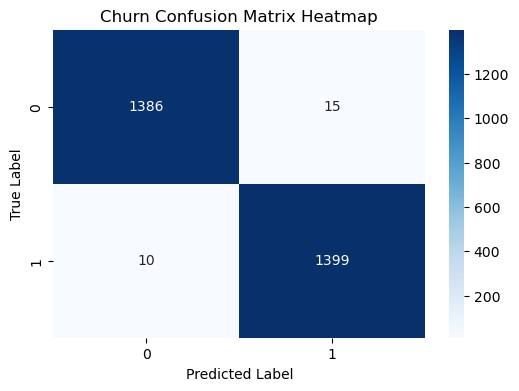

In [32]:
conf_matrix = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Churn Confusion Matrix Heatmap')
plt.show()

In [33]:
import pickle

In [34]:
pickle.dump(scaler,open("scaler_raw.pkl","wb"))

In [35]:
pickle.dump(adaboost_best,open("adaboost_best_raw.pkl","wb"))